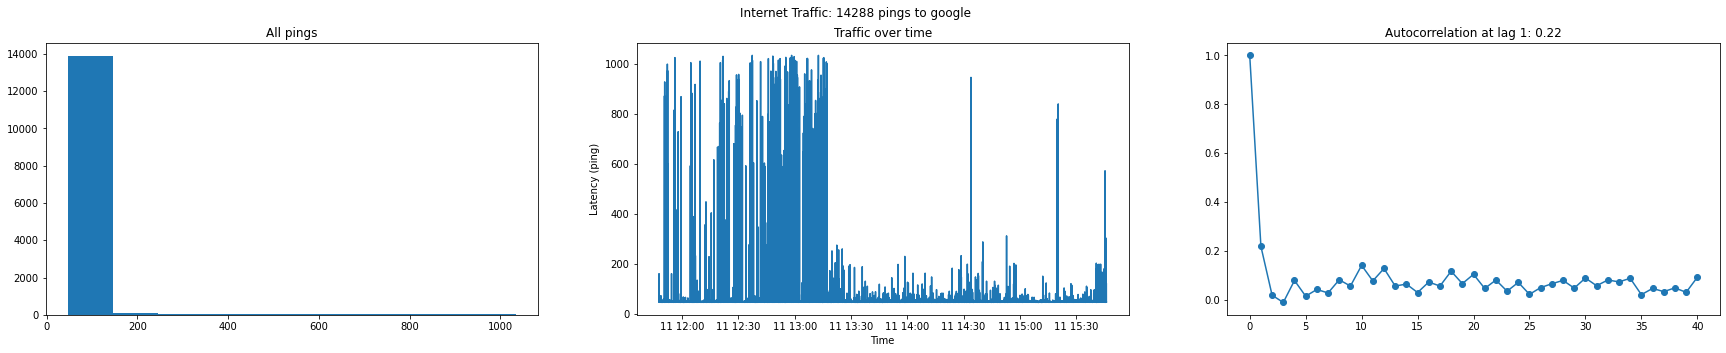

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from statsmodels.tsa import stattools
from IPython.display import HTML
import datetime

pd.set_option('max_colwidth', 1000)

def remove_headers(df):
    """ Remove the records when the ping command starts. """
    return df[df['a'].apply(lambda x: x[:4] != 'PING')]


def clean_time(time):
    """ Get to the right of time=, replace whitespace. """
    return float(re.sub('[\s|m|s]', '', time.split('time=')[1]))

def clean_ts(time):
    """Input is a string, cleaning. 
    
    >>> clean_ts('[1591899674.439142]')
    datetime.datetime(2020, 6, 11, 14, 21, 14, 439142)
    """
    return datetime.datetime.fromtimestamp(float(re.sub('[\[\]]', '', time)))


def parse_time(df):
    """ Grab the time of the ping and the amount of time 
    the ping took"""
    return (
        df
        .assign(tstamp = df.a.apply(lambda x: clean_ts(x[:19])))
        .assign(lat = df.b.apply(clean_time))
    )


def read_cleaned(n=100):
    return (
        pd.read_fwf('~/PING_LOG.txt', header=None, names=['a', 'b']).tail(n)
            .pipe(remove_headers)
            .pipe(parse_time)
            .drop(labels=['a', 'b'], axis=1)
    )

clean = read_cleaned(1000000)
autocor = stattools.acf(clean['lat'], fft=False)

clean.set_index('tstamp', inplace=True)

# Doing it this way bc I literally always forget
WIDTH = 30
HEIGHT = 5
fig, axs = plt.subplots(figsize=(WIDTH,HEIGHT), nrows=1,ncols=3)
fig.suptitle('Internet Traffic: {} pings to google'.format(clean.shape[0]))

axs[0].hist(clean['lat']);
axs[0].set_title('All pings');

axs[1].plot(clean['lat']);
axs[1].set_xlabel('Time');
axs[1].set_ylabel('Latency (ping)');
axs[1].set_title('Traffic over time')

axs[2].plot(autocor, marker='o')
axs[2].set_title('Autocorrelation at lag 1: {:.2f}'.format(autocor[1]));

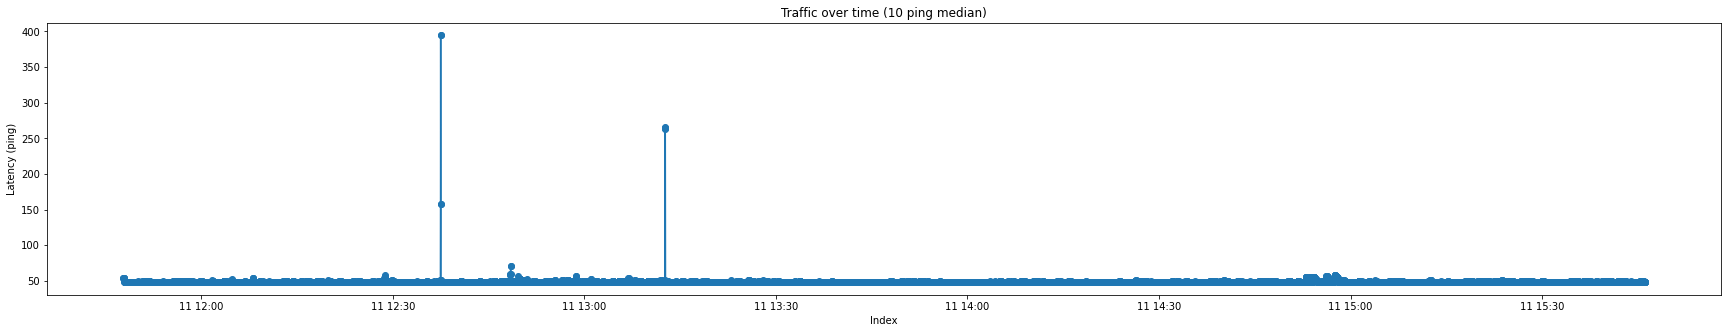

In [2]:
WIDTH = 30
HEIGHT = 5
fig, axs = plt.subplots(figsize=(WIDTH,HEIGHT), nrows=1, ncols=1)

WINDOW = 10
axs.plot(clean['lat'].rolling(WINDOW).median(), marker='o');
axs.set_xlabel('Index');
axs.set_ylabel('Latency (ping)');
axs.set_title('Traffic over time ({} ping median)'.format(WINDOW));

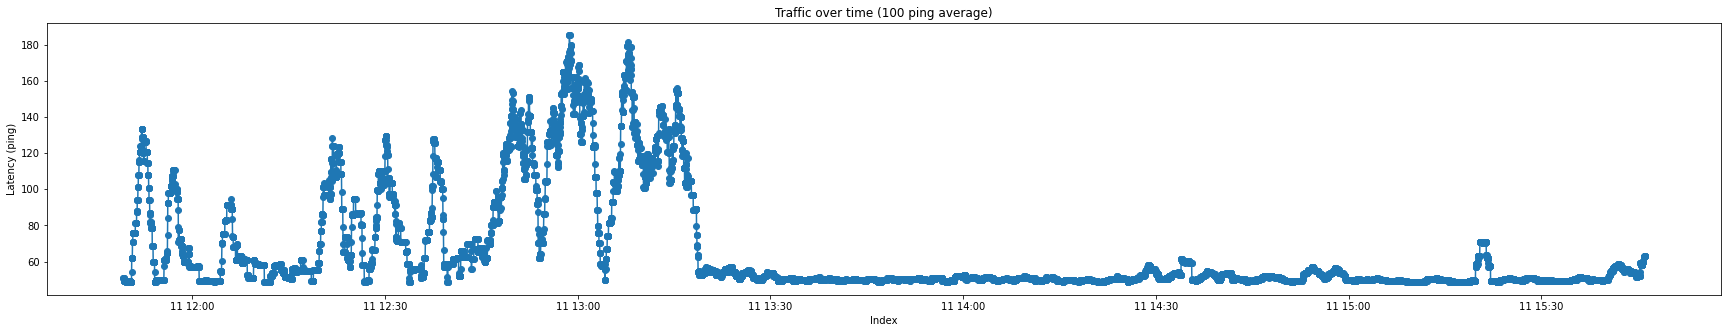

In [3]:
WIDTH = 30
HEIGHT = 5
fig, axs = plt.subplots(figsize=(WIDTH,HEIGHT), nrows=1, ncols=1)

WINDOW = 100
axs.plot(clean['lat'].rolling(WINDOW).mean(), marker='o');
axs.set_xlabel('Index');
axs.set_ylabel('Latency (ping)');
axs.set_title('Traffic over time ({} ping average)'.format(WINDOW));